In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import os
import astropy.io.fits as fits
from astropy.table import Table, Column
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask
from desiutil.plots import prepare_data, init_sky, plot_sky_circles, plot_sky_binned
from desiutil.log import get_logger
import warnings
import mpl_toolkits
%matplotlib inline

In [2]:
import desisurvey
import desisurvey.ephemerides

In [7]:
topdir = os.path.join("/global/cscratch1/sd/forero/quicksurvey2017b/")

In [8]:
ls $topdir

commands.sh*   fiberassign/      survey/   zcat/
commands.sh~*  fiberassign.log*  targets/


# MWS Results

In [ ]:
!ls -lhtr $topdir/zcat/bright/34/zcat.fits

In [11]:
zcat_path = '{topdir}/zcat/bright/34/zcat.fits'.format(topdir=topdir)
zcat = Table.read(zcat_path)

In [12]:
print((zcat['SPECTYPE'] == 'GALAXY').sum())
print((zcat['SPECTYPE'] == 'STAR').sum())
len(zcat)

17095205
10668205


27763410

In [13]:
zcat[0:3]

TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
288230376151711750,,GALAXY,0.248714,5.41471e-05,0,3
288230376151711759,,GALAXY,0.235782,5.35852e-05,0,1
288230376151711760,,GALAXY,0.220773,5.29372e-05,0,1


# Survey Schedule

In [14]:
ls $topdir/survey

config.yaml*                       plan_2024-09-05.fits*
ephem_2019-12-01_2024-11-30.fits*  progress.fits*
exposures.fits*                    progress_2020-05-12.fits*
exposures_bright.fits*             progress_2020-05-20.fits*
exposures_dark.fits*               progress_2020-05-29.fits*
fiberassign_dates_bright.txt*      progress_2020-06-27.fits*
fiberassign_dates_dark.txt*        progress_2020-10-16.fits*
last_date.txt*                     progress_2020-11-06.fits*
plan.fits*                         progress_2021-03-04.fits*
plan_2020-05-12.fits*              progress_2021-04-01.fits*
plan_2020-05-20.fits*              progress_2021-05-01.fits*
plan_2020-05-29.fits*              progress_2021-05-13.fits*
plan_2020-06-27.fits*              progress_2021-05-16.fits*
plan_2020-10-16.fits*              progress_2021-11-07.fits*
plan_2020-11-06.fits*              progress_2022-01-14.fits*
plan_2021-03-04.fits*              progress_2022-01-27.fits*
plan_2021-04-01.fits*              prog

There are 35 epochs in this survey: one of 6 months at the start, then (almost) every month thereafter.

In [15]:
!wc -l $topdir/survey/fiberassign_dates_bright.txt
!cat $topdir/survey/fiberassign_dates_bright.txt

35 /global/cscratch1/sd/forero/quicksurvey2017b//survey/fiberassign_dates_bright.txt
2019-12-01
2020-06-05
2020-07-04
2020-08-02
2020-10-01
2020-10-30
2020-11-29
2020-12-29
2021-01-27
2021-03-27
2021-04-26
2021-05-25
2021-06-23
2021-07-23
2021-09-20
2021-10-19
2021-11-18
2021-12-18
2022-01-17
2022-03-17
2022-04-15
2022-05-15
2022-06-13
2022-07-12
2022-09-09
2022-10-09
2022-11-07
2022-12-07
2023-01-06
2023-03-06
2023-04-05
2023-05-04
2023-06-03
2023-07-02
2023-07-31


In [16]:
our_ephem = Table.read("{topdir}/survey/ephem_2019-12-01_2024-11-30.fits".format(topdir=topdir))
weather   = Table.read("{topdir}/survey/weather_123.fits".format(topdir=topdir))
plan      = Table.read("{topdir}/survey/plan.fits".format(topdir=topdir))
exposures = Table.read("{topdir}/survey/exposures_bright.fits".format(topdir=topdir))
stats     = Table.read("{topdir}/survey/stats.fits".format(topdir=topdir))

## Twilight time

In [18]:
len(np.unique(exposures['night']))

597

In [19]:
our_ephem[0:2]

noon,dusk,dawn,brightdusk,brightdawn,moonrise,moonset,moon_illum_frac,brightstart,brightstop,moon_ra [25],moon_dec [25],mars_ra [25],mars_dec [25],jupiter_ra [25],jupiter_dec [25],venus_ra [25],venus_dec [25],uranus_ra [25],uranus_dec [25],saturn_ra [25],saturn_dec [25],neptune_ra [25],neptune_dec [25]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
58818.7916667,58819.0648814,58819.5402392,58819.0580229,58819.5471045,58818.7738772,58819.2214304,0.315489669913,58819.2916667,58819.2916667,315.855105756 .. 328.313405912,-20.5423307847 .. -17.539536838,216.065378304 .. 216.708564259,-13.6575110791 .. -13.8767281034,269.764817088 .. 270.006987866,-23.2989208847 .. -23.3008047723,277.879049509 .. 279.241556201,-24.7291091375 .. -24.6841840177,31.2658515215 .. 31.236328578,12.1393935297 .. 12.1293820506,289.554894854 .. 289.663373708,-22.1289755824 .. -22.1167690065,347.457148572 .. 347.459515781,-6.50614868175 .. -6.50467317316
58819.7916667,58820.0649029,58820.5407486,58820.0580377,58820.5476203,58819.8006318,58820.2601936,0.407848006491,58820.2916667,58820.2916667,328.313405912 .. 340.121507654,-17.539536838 .. -13.8899876705,216.708564259 .. 217.353268758,-13.8767281034 .. -14.0943427305,270.006987866 .. 270.249789827,-23.3008047723 .. -23.3023052641,279.241556201 .. 280.602584172,-24.6841840177 .. -24.6267600112,31.236328578 .. 31.2073609524,12.1293820506 .. 12.1195694614,289.663373708 .. 289.772672548,-22.1167690065 .. -22.1043796725,347.459515781 .. 347.462410248,-6.50467317316 .. -6.5029759855


In [21]:
inoon     = our_ephem['noon'].searchsorted(exposures['mjd'],side='left')
ibdusk    = our_ephem['brightdusk'].searchsorted(exposures['mjd'],side='left')
idusk     = our_ephem['dusk'].searchsorted(exposures['mjd'],side='left')
idawn     = our_ephem['dawn'].searchsorted(exposures['mjd'],side='left')
ibdawn    = our_ephem['brightdawn'].searchsorted(exposures['mjd'],side='left')
ibtstart  = our_ephem['brightstart'].searchsorted(exposures['mjd'],side='left')
ibtstop   = our_ephem['brightstop'].searchsorted(exposures['mjd'],side='left')

In [22]:
# This illustrates the logic used in the follow cell
slc = slice(0,20)
print(' N',inoon[slc])
print('BT',ibdusk[slc])
print(' T',idusk[slc])
print('B0',ibtstart[slc])
print('B1',ibtstop[slc])
print(' D',idawn[slc])
print('BD',ibdawn[slc])

 N [1 1 1 1 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5]
BT [1 1 1 1 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5]
 T [0 1 1 1 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5]
B0 [0 0 1 1 3 3 3 3 3 3 3 4 4 4 4 5 5 5 5 5]
B1 [0 0 1 1 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4]
 D [0 0 0 0 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4]
BD [0 0 0 0 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4]


In [23]:
is_btp              = (ibtstart == inoon) & (ibtstart > ibtstop)

is_bright_dusk      = (ibdusk   == inoon) & (ibdusk   > idusk)
is_dusk             = (idusk    == inoon) & (ibdusk  == idusk) & ~is_btp
is_dawn             = (idawn    == inoon) & (ibdawn   < idawn) & ~is_btp
is_bright_dawn      = (ibdawn   == inoon) & (ibdawn  == idawn)

# brightstart and brightstop have to be between dusk and dawn; they correspond to the
# period over which bright (moon) conditions prevail on an otherwise dark night.

is_btp_dusk             = (idusk    == inoon) & (ibdusk  == idusk) & is_btp
is_btp_dawn             = (idawn    == inoon) & (ibdawn   < idawn) & is_btp

# max_moon_illumination: 0.6
# max_moon_illumination_altitude_product: 30 deg

print('Total exposures: %d'%(len(exposures)))
print()
print('Bright dusk:     %d'%(is_bright_dusk.sum()))
print('Dusk:            %d'%(is_dusk.sum()))
print('Bright Time:     %d'%(is_btp.sum()))
print('Dawn:            %d'%(is_dawn.sum()))
print('Bright dawn:     %d'%(is_bright_dawn.sum()))
print('Sum:             %d'%(is_bright_dusk | is_dusk | is_btp | is_dawn | is_bright_dawn).sum())

Total exposures: 6689

Bright dusk:     537
Dusk:            2227
Bright Time:     3925
Dawn:            122
Bright dawn:     0
Sum:             6689


In [24]:
print('Total exposure time (hrs): %-5.2f'%(exposures['exptime'].sum()/3600.0))
print()
print('Bright dusk:     %-5.2f'%(exposures['exptime'][is_bright_dusk].sum()/3600.0))
print('Dusk:            %-5.2f'%(exposures['exptime'][is_dusk].sum()/3600.0))
print('Bright Time:     %-5.2f'%(exposures['exptime'][is_btp].sum()/3600.0))
print('Dawn:            %-5.2f'%(exposures['exptime'][is_dawn].sum()/3600.0))
print('Bright dawn:     %-5.2f'%(exposures['exptime'][is_bright_dawn].sum()/3600.0))

total_hours = exposures['exptime'][is_bright_dusk | is_dusk | is_btp | is_dawn | is_bright_dawn].sum()/3600.0
print('Sum:             %-5.2f'%(total_hours))
print()

supertwilight_hours_off_btp = exposures['exptime'][(is_bright_dusk | is_bright_dawn)].sum()/3600.0
twilight_hours_off_btp      = exposures['exptime'][(is_dusk | is_dawn)].sum()/3600.0

# The BTP is time that would be dark if it weren't for the Moon.
print('Fractions of total bright time in twilight:')
print('Bright twilight: %f'%(supertwilight_hours_off_btp/total_hours))
print('Normal twilight: %f'%(twilight_hours_off_btp/total_hours))

# Bright dusk: Sun alt. > -13
# Dusk       : Sun alt.   -13 to -15
# Dark       : Sun alt. < -15 and moon down
# Grey       : Sun alt. < -15 and moon up with some conditions
# Bright     : Sun alt. < -15 and moon up with other conditions

Total exposure time (hrs): 1141.42

Bright dusk:     85.57
Dusk:            362.95
Bright Time:     692.90
Dawn:            11.31
Bright dawn:     0.00 
Sum:             1141.42

Fractions of total bright time in twilight:
Bright twilight: 0.074969
Normal twilight: 0.317982


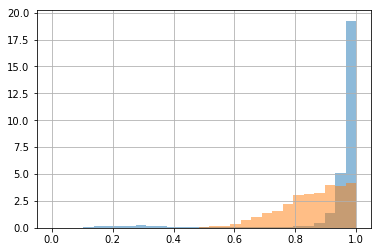

In [25]:
plt.hist(exposures['transparency'],bins=np.linspace(0,1,30),alpha=0.5,normed=True);
plt.hist(exposures['seeing'],bins=np.linspace(0,1,30),alpha=0.5,normed=True);
plt.grid()

## Exposure times

In [27]:
exposures[0:2]

tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,str10,float64,float64,float64,float64,float64,float64,float64,float64
34308,5,345.64,25.37,0.145557,2019-12-01,58819.0583701,686.255885087,0.993969678879,0.965001940727,1.01068331726,0.315489669913,34.1941411183,52.6531193026
33066,5,46.0,3.15,0.102859,2019-12-01,58819.2888944,879.862865864,0.976047694683,0.385159164667,1.18755670794,0.315489669913,-19.7502717695,86.767483742


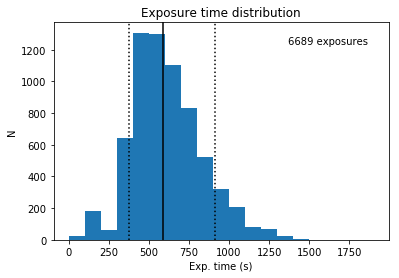

In [28]:
plt.hist(exposures['exptime'],bins=np.arange(0,2000,100))
plt.text(0.7,0.9,'%d exposures'%(len(exposures)),transform=plt.gca().transAxes)
percentiles = np.percentile(exposures['exptime'],[10,50,90])
plt.axvline(percentiles[0],c='k',ls=':')
plt.axvline(percentiles[1],c='k',ls='solid')
plt.axvline(percentiles[2],c='k',ls=':')
plt.xlabel('Exp. time (s)')
plt.ylabel('N')
plt.title('Exposure time distribution');

In [29]:
plan[0:5]

tileid,ra,dec,pass,priority,hourangle,covered,available
int32,float64,float64,int16,float64,float64,int64,bool
4,335.03,19.88,0,1.09507142857,-4.13891586268,-1,True
6,333.22,14.84,0,1.13107142857,-5.14379275346,-1,True
7,332.35,12.32,0,1.14907142857,-6.75987702507,-1,True
8,319.9,6.05,0,1.19385714286,-11.1294985935,-1,True
9,330.67,7.31,0,1.18485714286,-6.882876307,-1,True


In [30]:
weather[0:5]

mjd,open,seeing,transparency
float64,bool,float32,float32
58818.7916667,True,1.81396,0.961685
58818.7951389,True,1.61929,0.951094
58818.7986111,True,1.47662,0.967999
58818.8020833,True,1.92816,0.98349
58818.8055556,True,1.52703,0.945346


# Targets

In [31]:
ls $topdir/targets/bright/0/53

standards-bright-4-53.fits*  targets-4-53.fits*
standards-dark-4-53.fits*    truth-4-53.fits*


In [32]:
targets_onepix_path = '{topdir}/targets/bright/0/53/targets-4-53.fits'.format(topdir=topdir)
targets_path        = '{topdir}/targets/bright/targets.fits'.format(topdir=topdir)

In [33]:
t_onepix = Table.read(targets_onepix_path)
print(len(t_onepix),'rows')

111256 rows


In [34]:
t_onepix[0:3]

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,SUBPRIORITY,OBSCONDITIONS
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,float64,int64
0,3460p337,0,345.95880127,33.7933959961,4.38655,11.1833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724577,0.804916,0.884802,0.981725,0.988737,288230376374009856,1152921504606846976,65537,0,53,0.00959843053743,7
0,3469p340,0,347.010406494,34.1110343933,19.19,25.5279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.77606,0.843008,0.908178,0.985591,0.991126,288230376374009857,1152921504606846976,131074,0,53,0.969758559448,4
0,3484p340,0,348.460510254,34.0122909546,10.9261,16.2791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.829251,0.881507,0.931341,0.989338,0.993439,288230376374009858,1152921504606846976,131074,0,53,0.984668125654,4


## Confusion of BGS and MWS targets

In [35]:
odd = np.where(t_onepix['BGS_TARGET'] & t_onepix['MWS_TARGET'])

In [36]:
print(np.unique(t_onepix[odd]['BGS_TARGET']))
print(np.unique(t_onepix[odd]['MWS_TARGET']))

BGS_TARGET
----------
     65537
MWS_TARGET
----------
     65536


In [37]:
bgs_mask.names(65537)

['BGS_FAINT', 'BGS_FAINT_SOUTH']

In [38]:
mws_mask.names(65536)

['MWS_MAIN_VERY_FAINT']